In [1]:
import pyodbc
import pandas as pd
import numpy as np
import os
import pickle
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from bqplot import pyplot as bplt
import seaborn as sns
#import voila
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
#mpl.rc('font',family='Segoe UI')
#plt.style.use("seaborn-v0_8-white")
#os.chdir("C:\\Users\\gcubb\\OneDrive\\Family\\College")

In [2]:
def get_ts_data_multi(cdat,schnames,flds):
    #get all values of fld from cdat, which is a wide panel with year and UNITID fields
    maxyr = np.max(cdat.year) 
    idnm = cdat[cdat.year==maxyr][['UNITID','INSTNM']].set_index('UNITID')
    schids = idnm[idnm['INSTNM'].isin(schnames)]
    tsd = cdat[cdat.UNITID.isin(schids.index)][flds+['year','INSTNM']].set_index('year').sort_index()
    return tsd

def add_to_dat(origdata):
    ts_dat = origdata.rename(columns={'DVADM08':'admYieldMen','DVADM09':'admYieldWom','NPT430':'netPrcU75','NPT440':'netPrcU110','NPT450':'netPrcOver110'})
    ts_dat['percRoom'] = 100*ts_dat['ROOMCAP']/ts_dat['ADMSSN']
    ts_dat['percAdm'] = 100*ts_dat['ADMSSN']/ts_dat['APPLCN']
    ts_dat['percAdmMen'] = 100*ts_dat['ADMSSNM']/ts_dat['APPLCNM']
    ts_dat['percAdmWom'] = 100*ts_dat['ADMSSNW']/ts_dat['APPLCNW']
    ts_dat['citystate'] = ts_dat['CITY']+', '+ts_dat['STABBR']
    localemap = {11	:'City: Large'
    ,12	:'City: Midsize'
    ,13	:'City: Small'
    ,21	:'Suburb: Large'
    ,22	:'Suburb: Midsize'
    ,23	:'Suburb: Small'
    ,31	:'Town: Fringe'
    ,32	:'Town: Distant'
    ,33	:'Town: Remote'
    ,41	:'Rural: Fringe'
    ,42	:'Rural: Distant'
    ,43	:'Rural: Remote'
    ,-3	:'Not available'}
    ts_dat['localdesc'] = ts_dat['LOCALE'].map(localemap)
    return ts_dat

def pltmult(ax, df, varcho, xlab, ylab):
    ax = sns.lineplot(data=df, x=df.index, y=varcho[0], hue='INSTNM')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.legend()
    ax.grid()
    #set x axis gridlines to 1 year increments
    ax.set_xticks(df.index)
    return ax

In [3]:
fnm = 'ipedsData_2014_2022'
#coll = pd.ExcelFile("C:\\Users\\gcubb\\OneDrive\\Family\\College\\college_data_fields.xlsx").parse('fields',skiprows=0) 
#dwd  = buildcollegedb(fnm,list(coll['varName'])) #may need to do outer join merges as some tables may only be for certain types of schools

with open(fnm+".pickle","rb") as f:
    cdat = pickle.load(f)

Button(button_style='info', description='Run Report', icon='search', style=ButtonStyle(), tooltip='Run Report'…

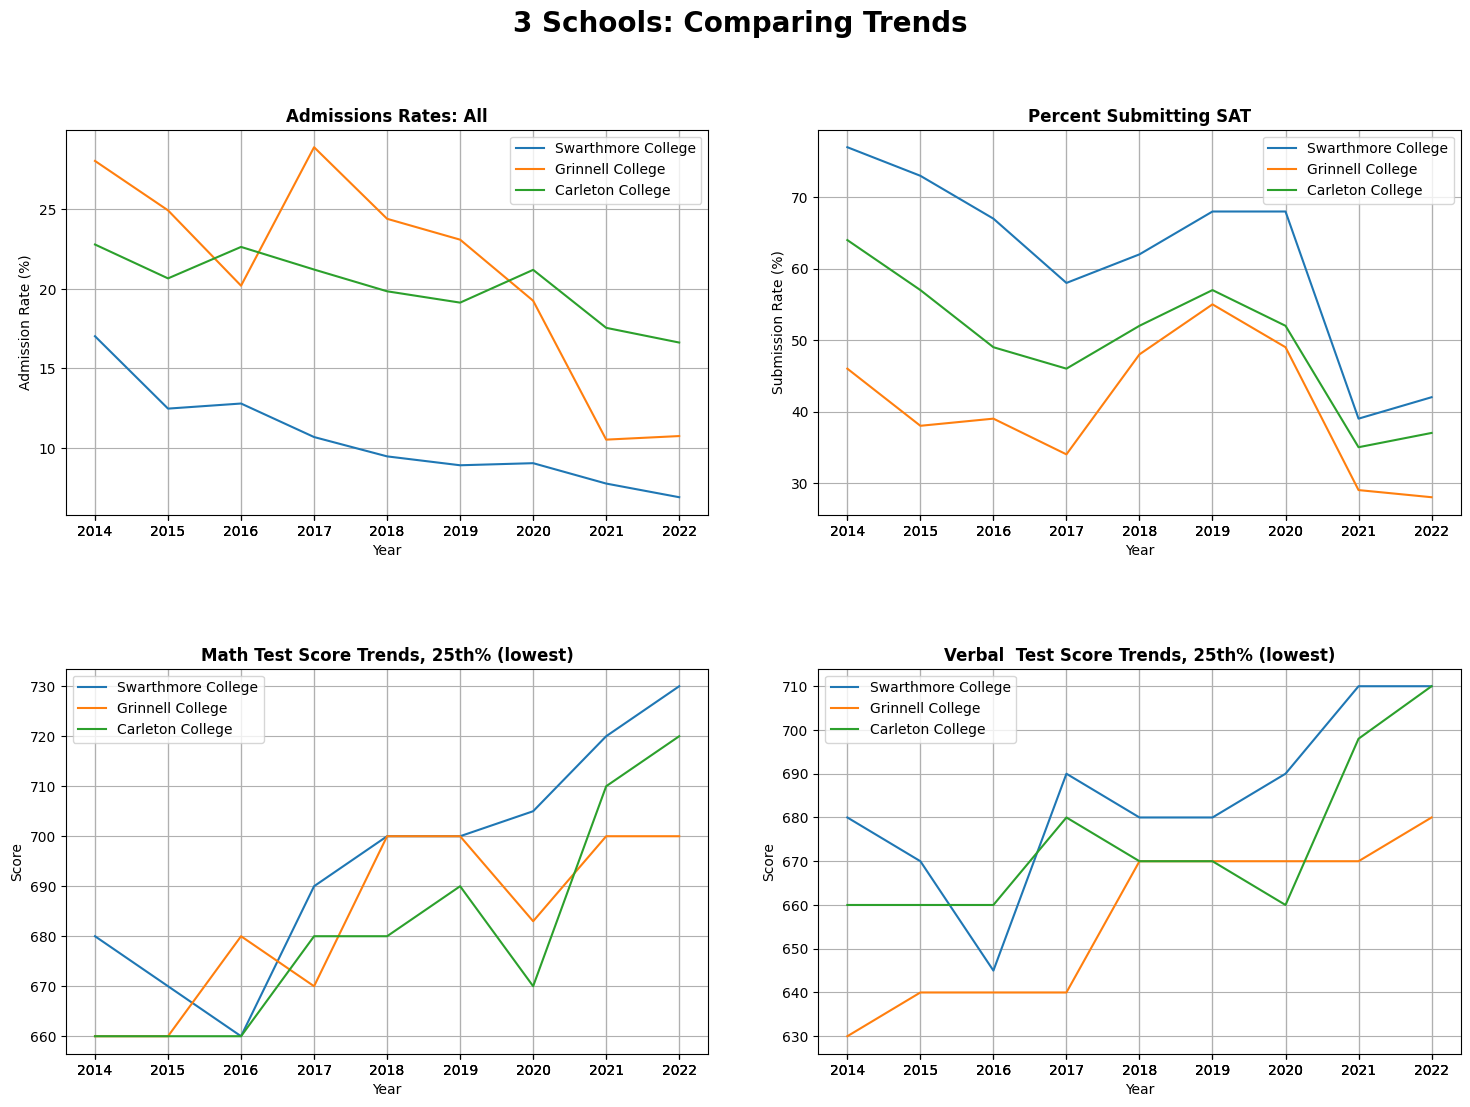

In [ ]:
univsnippet1 = widgets.Text(value='Grinn',placeholder='Enter part of college name',description='Search #1:',disabled=False,continuous_update=False)
univsnippet2 = widgets.Text(value='Carle',placeholder='Enter part of college name',description='Search #2:',disabled=False,continuous_update=False)
univsnippet3 = widgets.Text(value='Swarth',placeholder='Enter part of college name',description='Search #3:',disabled=False,continuous_update=False)

schchoice1 = widgets.Dropdown(options=['Grinnell College'],value='Grinnell College',description='Choose #1:',disabled=False)
schchoice2 = widgets.Dropdown(options=['Carleton College'],value='Carleton College',description='Choose #2:',disabled=False)
schchoice3 = widgets.Dropdown(options=['Swarthmore College'],value='Swarthmore College',description='Choose #3:',disabled=False)

runrpt = widgets.Button(description='Run Report',disabled=False,button_style='info', tooltip='Run Report',icon='search' )
#out=widgets.Output()

def create_data_multi(b=None):
    #schname = schchoice.value
    schnames = [schchoice1.value,schchoice2.value,schchoice3.value]
    flds = ['ADMSSN','APPLCN','ADMSSNM','APPLCNM','ADMSSNW','APPLCNW','SATVR25','SATVR75','SATMT25','ENRLFTM','ENRLFTW','SATMT75', 'DVADM08', 'DVADM09'
            ,'SATPCT','ACTPCT','NPT430','NPT440','NPT450','CALSYS','CITY','STABBR','OBEREG','LOCALE','ROOMCAP','RMBRDAMT']
    ts_dat_orig = get_ts_data_multi(cdat,schnames,flds)
    ts_dat = add_to_dat(ts_dat_orig)
    return ts_dat

def schlistm(snipval):
    schoollist=[]
    idnm = cdat[['UNITID','INSTNM']].set_index('UNITID')
    schid = idnm[idnm['INSTNM'].str.contains(snipval)]
    slist = schid.INSTNM.unique()
    schoollist = slist.copy()
    return schoollist

#@out.capture(clear_output=True)
def run_report_multi(tmult, schnamesarg):
    fig = plt.figure(figsize=(18,12))
    gs = fig.add_gridspec(2,15)
    fig.suptitle(f"3 Schools: Comparing Trends", fontsize=20, fontweight='bold')
    fig.subplots_adjust(hspace = 0.4)

    ax = fig.add_subplot(gs[0,0:7])
    varchoice = ['percAdm']
    ax.set_title("Admissions Rates: All", fontsize=12, fontweight='bold')
    ax = pltmult(ax, tmult, varchoice, "Year", "Admission Rate (%)")
    
    ax = fig.add_subplot(gs[0,8:15])
    varchoice = ['SATPCT']
    ax.set_title("Percent Submitting SAT", fontsize=12, fontweight='bold')
    ax = pltmult(ax, tmult.fillna(""), varchoice, "Year", "Submission Rate (%)")

    ax = fig.add_subplot(gs[1,0:7])
    varchoice = ['SATMT25']
    ax.set_title("Math Test Score Trends, 25th% (lowest)", fontsize=12, fontweight='bold')
    ax = pltmult(ax, tmult.fillna(""), varchoice, "Year", "Score")

    ax = fig.add_subplot(gs[1,8:15])
    varchoice = ['SATVR25']
    ax.set_title("Verbal  Test Score Trends, 25th% (lowest)", fontsize=12, fontweight='bold')
    ax = pltmult(ax, tmult.fillna(""), varchoice, "Year", "Score") 

@univsnippet1.observe
def school_on_click(b):
    schchoice1.options=schlistm(univsnippet1.value)
@univsnippet2.observe
def school_on_click(b):
    schchoice2.options=schlistm(univsnippet2.value)
@univsnippet3.observe
def school_on_click(b):
    schchoice3.options=schlistm(univsnippet3.value)

def rpt_on_click(b):
    clear_output()
    display(choicegrid, runrpt)  
    coldata = create_data_multi()
    schnames2 = [schchoice1.value,schchoice2.value,schchoice3.value]
    run_report_multi(coldata, schnames2)
    #tab = create_table(coldata)

def bqplot_on_click(b):
    clear_output()
    display(choicegrid, runrpt) 
    bplt.figure(1, title='Line Chart')
    np.random.seed(0)
    n = 200
    x = np.linspace(0.0, 10.0, n)
    y = np.cumsum(np.random.randn(n))
    bplt.plot(x, y)
    bplt.show()

runrpt.on_click(rpt_on_click)
#runrpt.on_click(school_on_click)
#runrpt.on_click(bqplot_on_click)


searchboxes = widgets.VBox([univsnippet1,univsnippet2,univsnippet3])
choiceboxes = widgets.VBox([schchoice1,schchoice2,schchoice3])
choicegrid = widgets.HBox([searchboxes,choiceboxes])
#rptbutton = widgets.HBox([runrpt])
display(choicegrid, runrpt) 